In [2]:
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C
import cntk.tests.test_utils

#cntk.tests.test_utils.set_device_from_pytest_env()
C.cntk_py.set_fixed_random_seed(1)

%matplotlib inline

In [3]:
input_dim_model = (1, 28, 28)
input_dim = 28 * 28
num_output_classes = 10

In [4]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [5]:
# Ensure the training and test data is available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.

data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    
    train_file=os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file=os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


In [6]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

In [7]:
def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        h = features
        h = C.layers.Convolution2D(filter_shape=(5, 5),
                                  num_filters=8,
                                  strides=(2,2),
                                  pad=True, name='first_conv')(h)
        h = C.layers.Convolution2D(filter_shape=(5, 5),
                                  num_filters=16,
                                  strides=(2,2),
                                  pad=True, name='second_conv')(h)
        r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
        return r

In [8]:
z = create_model(x)

print("Output Shape of the first convolution layer:", z.first_conv.shape)
print("Bias value of the last dense layer:", z.classify.b.value)

Output Shape of the first convolution layer: (8, 14, 14)
Bias value of the last dense layer: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [9]:
C.logging.log_number_of_parameters(z)

Training 11274 parameters in 6 parameter tensors.


In [10]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs

In [11]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

In [12]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    learning_rate = 0.2
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    #learner = C.sgd(z.parameters, lr_schedule)
    m = C.momentum_schedule(0.9)
    learner = C.adam(z.parameters, lr_schedule, m)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = 64
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 500
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size = 512
    num_samples = 10000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

In [13]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
do_train_test()

Minibatch: 0, Loss: 2.3093, Error: 89.06%
Minibatch: 500, Loss: 0.1887, Error: 9.38%
Minibatch: 1000, Loss: 0.0366, Error: 1.56%
Minibatch: 1500, Loss: 0.0673, Error: 0.00%
Minibatch: 2000, Loss: 0.0058, Error: 0.00%
Minibatch: 2500, Loss: 0.0090, Error: 0.00%
Minibatch: 3000, Loss: 0.0278, Error: 1.56%
Minibatch: 3500, Loss: 0.0427, Error: 1.56%
Minibatch: 4000, Loss: 0.0297, Error: 1.56%
Minibatch: 4500, Loss: 0.0220, Error: 1.56%
Minibatch: 5000, Loss: 0.0032, Error: 0.00%
Minibatch: 5500, Loss: 0.0007, Error: 0.00%
Minibatch: 6000, Loss: 0.0156, Error: 1.56%
Minibatch: 6500, Loss: 0.0191, Error: 1.56%
Minibatch: 7000, Loss: 0.0018, Error: 0.00%
Minibatch: 7500, Loss: 0.0037, Error: 0.00%
Minibatch: 8000, Loss: 0.0002, Error: 0.00%
Minibatch: 8500, Loss: 0.0052, Error: 0.00%
Minibatch: 9000, Loss: 0.0011, Error: 0.00%
Training took 86.1 sec
Average test error: 1.39%


In [14]:
out = C.softmax(z)

In [15]:
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels}

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

img_data = np.reshape(img_data, (eval_minibatch_size, 1, 28, 28))

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [16]:
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [17]:
print("Label   :", gtlabel[:25])
print("Predicted:", pred)

Label   : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
Predicted: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5, 4]


Image Label:  1


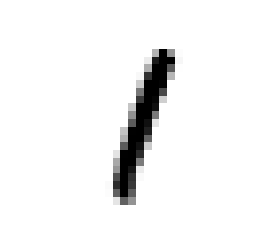

In [18]:
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28, 28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

In [19]:
def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.relu):
        h = features
        
        h = C.layers.Convolution2D(filter_shape=(5, 5),
                                  num_filters=8,
                                  strides=(1,1),
                                  pad=True, name="first_conv")(h)
        h = C.layers.MaxPooling(filter_shape=(2,2),
                               strides=(2,2), name="first_max")(h)
        h = C.layers.Convolution2D(filter_shape=(5, 5),
                                  num_filters=16,
                                  strides=(1,1),
                                  pad=True, name="second_conv")(h)
        h = C.layers.MaxPooling(filter_shape=(2,2),
                               strides=(2,2), name="second_max")(h)
        r = C.layers.Dense(num_output_classes, activation = None, name="classify")(h)
        return r
    
do_train_test()

Minibatch: 0, Loss: 2.3210, Error: 92.19%
Minibatch: 500, Loss: 0.1180, Error: 4.69%
Minibatch: 1000, Loss: 0.0719, Error: 1.56%
Minibatch: 1500, Loss: 0.0631, Error: 1.56%
Minibatch: 2000, Loss: 0.0013, Error: 0.00%
Minibatch: 2500, Loss: 0.0045, Error: 0.00%
Minibatch: 3000, Loss: 0.0022, Error: 0.00%
Minibatch: 3500, Loss: 0.0661, Error: 1.56%
Minibatch: 4000, Loss: 0.0053, Error: 0.00%
Minibatch: 4500, Loss: 0.0038, Error: 0.00%
Minibatch: 5000, Loss: 0.0266, Error: 1.56%
Minibatch: 5500, Loss: 0.0037, Error: 0.00%
Minibatch: 6000, Loss: 0.0436, Error: 1.56%
Minibatch: 6500, Loss: 0.0084, Error: 0.00%
Minibatch: 7000, Loss: 0.0116, Error: 0.00%
Minibatch: 7500, Loss: 0.0034, Error: 0.00%
Minibatch: 8000, Loss: 0.0049, Error: 0.00%
Minibatch: 8500, Loss: 0.0078, Error: 0.00%
Minibatch: 9000, Loss: 0.0010, Error: 0.00%
Training took 247.0 sec
Average test error: 1.19%
